# IMDB Hugging Face movie review sentiment classification with distilbert model with TensorFlow

The main purpose of this excercise is to make use of Hugging Face resources to train a model with TensorFlow, to study the implementation details.

In [1]:
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, TFDistilBertModel
from tensorflow.keras import layers, models
import pandas as pd


c:\Users\USER\.conda\envs\tf2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
data = load_dataset("ajaykarthick/imdb-movie-reviews")
train_data_raw = data['train']['review']
train_labels = data['train']['label']
test_data_raw = data['test']['review']
test_labels = data['test']['label']

In [4]:
print(len(train_data_raw))
print(len(test_data_raw))
print(train_data_raw[0:3])
print(train_labels[0:3])

40000
10000
["Ms Aparna Sen, the maker of Mr & Mrs Iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />Meethi (Konkona Sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. The dormant tendency however slips out of control, when the job assignment takes her to neighboring Bihar where she's raped by some political goons. The resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. She careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />The juxtaposition of an 'unsettled' (divorced) elder sister and how her domineering ways make an already bad situation worse, is indicative of what a fine line there is between abnormal and *seemingly normal*. Ms Sen also makes an excellent commentary on the social alienation of such individuals. Social rehab is standard therapy along with a

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512, # TODO: 512
        return_tensors='tf'
    )

train_data_raw = tokenize(train_data_raw)
test_data_raw = tokenize(test_data_raw)

In [6]:
print(type(train_data_raw))
print(train_data_raw[0])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
# IMPORTANT: check out tokenized data from the dataset
# it is stored in the field 'input_ids'
train_data_raw['input_ids']

<tf.Tensor: shape=(40000, 512), dtype=int32, numpy=
array([[ 101, 5796, 9706, ..., 2064, 1998,  102],
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0],
       ...,
       [ 101, 1037, 3522, ..., 4962, 4938,  102],
       [ 101, 7619, 2442, ...,    0,    0,    0],
       [ 101, 2023, 2003, ...,    0,    0,    0]])>

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
  (
    train_data_raw['input_ids'],
    train_labels
  )
).batch(32)

test_data = tf.data.Dataset.from_tensor_slices(
  (
    test_data_raw['input_ids'],
    test_labels
  )
).batch(32)

In [25]:
train_data.element_spec

(TensorSpec(shape=(None, 512), dtype=tf.int32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# FIXME:
# There are some warnings in the output cells: "Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel"
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert/distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [43]:
class DistilbertBaseLayer(tf.keras.layers.Layer):
    def __init__(self, trainable: bool = True, **kwargs):
        super(DistilbertBaseLayer, self).__init__(**kwargs)
        # There are some warnings in the output cells: "Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel"
        self.distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.distilbert_model.trainable = trainable
    def call(self, inputs):
        return self.distilbert_model(inputs)[0][:, 0, :]

def create_model0(trainable: bool = True):
    inputs = tf.keras.Input(shape=512, dtype=tf.int32)
    x = inputs
    x = DistilbertBaseLayer(trainable)(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

with tf.device('/GPU:0'):
    model0 = create_model0(trainable=False)
    model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model0.summary()

# For Windows, a warning about developer mode is displayed. Please turn it on if you want to use symlinks.
# https://learn.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512)]             0         
                                                                 
 distilbert_base_layer_7 (Di  (None, 768)              66362880  
 stilbertBaseLayer)                                              
                                                                 
 dropout_140 (Dropout)       (None, 768)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 769       
                                                                 
Total params: 66,363,649
Trainable params: 769
Non-trainable params: 66,362,880
_________________________________________________________________


Epoch 1/5
125/125 [==============================] - 392s 3s/step - loss: 0.7255 - accuracy: 0.5178 - val_loss: 0.6924 - val_accuracy: 0.5202 - lr: 1.0000e-04
Epoch 2/5
125/125 [==============================] - 391s 3s/step - loss: 0.7100 - accuracy: 0.5365 - val_loss: 0.6746 - val_accuracy: 0.6199 - lr: 3.1623e-04
Epoch 3/5
125/125 [==============================] - 389s 3s/step - loss: 0.6740 - accuracy: 0.5792 - val_loss: 0.6358 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 4/5
125/125 [==============================] - 389s 3s/step - loss: 0.6125 - accuracy: 0.6745 - val_loss: 0.5647 - val_accuracy: 0.7644 - lr: 0.0032
Epoch 5/5
125/125 [==============================] - 391s 3s/step - loss: 0.5721 - accuracy: 0.6992 - val_loss: 0.4889 - val_accuracy: 0.7837 - lr: 0.0100


<Axes: >

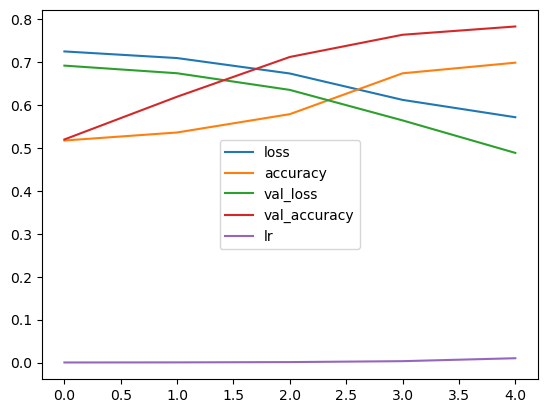

In [ ]:
# This training is to find the optimal learning rate for the model

history0 = model0.fit(
  train_data,
  steps_per_epoch=round(0.1 * len(train_data)),
  epochs=5,
  validation_data=test_data,
  validation_steps=round(0.5 * len(test_data)),
  callbacks=[
    tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 10 ** (-4 + epoch * 0.5) # from 0.0001 to 0.01
    )
  ]
)

pd.DataFrame(history0.history).plot()

In [ ]:
# After the training above, it seems that 0.001 is a good learning rate. Let's use it.
# Create the model again and perform training with more data.

with tf.device('/GPU:0'):
    model0 = create_model0(trainable=False)
    model0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history0 = model0.fit(
  train_data.repeat(), # is repeat neccessary here?
  steps_per_epoch=round(0.25 * len(train_data)),
  epochs=5,
  validation_data=test_data,
  validation_steps=round(0.5 * len(test_data)),
)

pd.DataFrame(history0.history).plot()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5


KeyboardInterrupt: 

In [48]:
model.save("checkpoint/distilbert-base-uncased-0")

INFO:tensorflow:Assets written to: checkpoint/distilbert-base-uncased-0\assets


INFO:tensorflow:Assets written to: checkpoint/distilbert-base-uncased-0\assets
